## Introduction

In this activity we will explore first order kinetic reactions and see how we use analytical solutions to model the transport of solutes undergoing combined first order reactions and sorption reactions.

In [1]:
# Import the neccesary libraries
from scipy.special import erfc as erfc
import numpy as np
import math
import matplotlib.pyplot as plt

## First order kinetic reactions
Let's start with a few different radioisotopes with different half-lifes.

$^{[18]}$F$_{t_{1/2}}=110$ min - positron-emitting isotope used in PET imaging experiments)

$^{[222]}$R$_{t_{1/2}}=3.8$ days - Radon-222 is a dangerous isotope in the environment because its longer half-life allows it to permeate soil and rocks, where it is produced in trace quantities from decays of uranium-238, and concentrates in buildings and uranium mines.

$^{[137]}$Cs$_{t_{1/2}}=30.17$ yrs - Caesium-137 is one of the principal sources of radiation in the zone of alienation around the [Chernobyl nuclear power plant](https://www.hbo.com/chernobyl), and poses health risks due to the long half-life and biological uptake.

In [2]:
# Define the half lifes in minutes
half_life_f18 = 110
half_life_r222 = 3.8*24*60
half_life_cs137 = 30.17*365.25*24*60

Let's define a function that takes a half-life ('t_half') and arrays of time ('t') in matching units to give concentration of isotope as a function of time.

In [3]:
# finish this function based on the equation from class
def first_order_decay(t, t_half, C0):
    C = 0 # fill in the correct equation!
    return C

In [4]:
# define our time array
t = np.linspace(0, half_life_f18*15, num=100)

Text(0, 0.5, 'Normalized concentration [-]')

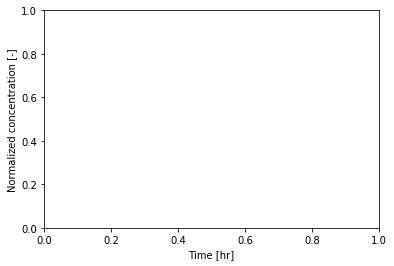

In [5]:
# Call our function and plot the result (this will spit out errors until the function is properly defined)
C_f18 = first_order_decay(t, half_life_f18, 1)

# plt.plot(t/60, C_f18, label='F_{18}')
plt.xlabel('Time [hr]')
plt.ylabel('Normalized concentration [-]')

#### What would the Radon-222 line look like over the same time? If this is the timescale of the transport processes, what isotope can be considered an equilibrium reaction and which should be treated as a kinetic reaction?

## Analytical transport model 
### Setup

Now let's use an analytical model to describe the transport of a solute experiencing a first-order reaction in a similiar column-scale system that we explored in our conservative solute examples. For conceptual simplicity lets imagine a homogenous sand column, similiar to the ones you worked with in lab in GEOSCI/GEOENG 627. First define the initial (t=0) conditions (Ci) and boundary conditions.

In [6]:
# length of experiment (time in seconds)
experiment_length = 60*180;
# define a time vector to calculate the analytical solution at many different times at once (this is vectorization!)
t = np.linspace(0.1, experiment_length, num=1000)
# If injecting a pulse give the time of pulse injection (in seconds)
# for t0. If modeling a continous source then t0 = 0
t0 = 0
# Injection rate (mL/min)
q = 2
# Injected concentration
C0 = 1
# Initial concentration
Ci = 0

Now lets define some (arbitrary) column properties

In [7]:
# Column length (cm)
x = 10
col_radius = 2.5
# porosity
phi = 0.3;
# dispersivity [cm] 
dispersivity = 0.3 

Note that the 'dispersivity' is the alpha in the equations from the course notes. Remember this must be multiplied by the advection velocity to get dispersion.

In [8]:
# calculate advection velocity
area = math.pi*(col_radius)**2
v = q/60/area/phi # divide by 60 to get flow rate from cm/min to cm/sec
print("advection velocity: " + str(v))

# Dispersion
D = v*dispersivity

advection velocity: 0.005658842421045167


### Reaction parameter input!

In [9]:
# porous medium bulk density [g/cm^3]
rhob = 1.700

# emperical distribution coefficient describing the linear 
# adsorption isotherm [L^3/Mass]
kd = 0.1

This linear sorption parameter $K_d$ is what we explored in the [Sorption Isotherms notebook](https://github.com/zahasky/Contaminant-Hydrogeology-Activities/blob/master/Sorption%20Isotherms.ipynb). For a refersher, review this notebook.

In [10]:
# zero-order liquid phase source term
gamma_w = 0.000
gamma_s = 0.00000

# first-order decay terms
# F18
mu_w = np.log(2)/(half_life_f18*60)

# first-order solid phase decay constant
mu_s = mu_w

What does this $\mu_w$ term correspond to in the course notes? What are the units?

In [11]:
# Sorption parameter calculation
# retardation factor (R)
R = 1 + rhob*kd/phi
print('Retardation factor: ' +str(R))

# general zero-order constant
gamma = gamma_w + gamma_s*rhob/phi

# general first-order decay constant 
mu = mu_w + mu_s*rhob*kd/phi

Retardation factor: 1.5666666666666669


### Analytical solution: Type 1 boundary conditions with retardation

Now is where things might get a little intimidating. These analytical solutions are really ugly looking but it's just more of the same of what we have already seen, now with a few extra parameters.

In [12]:
# Retardation with 1st type BC (equation C5)
# 'u' term identical in equation c5 and c6 (type 3 inlet)
# Write out the name of each of these variables
def ADEwReactions_type1_fun(x, t, v, D, R, gamma, mu, C0, t0, Ci):
    u = v*(1+(4*mu*D/v**2))**(1/2)
    
    # Note that the '\' means continued on the next line
    Atrf = np.exp(-mu*t/R)*(1- (1/2)* \
        erfc((R*x - v*t)/(2*(D*R*t)**(1/2))) - \
        (1/2)*np.exp(v*x/D)*erfc((R*x + v*t)/(2*(D*R*t)**(1/2))))
    
    # term with B(x, t)
    Btrf = 1/2*np.exp((v-u)*x/(2*D))* \
        erfc((R*x - u*t)/(2*(D*R*t)**(1/2))) \
        + 1/2*np.exp((v+u)*x/(2*D))* erfc((R*x + u*t)/ \
        (2*(D*R*t)**(1/2)))
    
    # if a pulse type injection
    if t0 > 0:
        tt0 = t - t0
        
        indices_below_zero = tt0 <= 0
        # set values equal to 1 (but this could be anything)
        tt0[indices_below_zero] = 1
    
        Bttrf = 1/2*np.exp((v-u)*x/(2*D))* \
            erfc((R*x - u*tt0)/(2*(D*R*tt0)**(1/2))) \
            + 1/2*np.exp((v+u)*x/(2*D))* erfc((R*x + u*tt0)/ \
            (2*(D*R*tt0)**(1/2)))
        
        # Now set concentration at those negative times equal to 0
        Bttrf[indices_below_zero] = 0
        if mu >0:
            C_out = (gamma/mu)+ (Ci- gamma/mu)*Atrf + \
                (C0 - gamma/mu)*Btrf - C0*Bttrf
        else:
            C_out = Ci*Atrf + C0 *Btrf - C0*Bttrf
            
    else: # if a continous injection then ignore the Bttrf term (no superposition)
        if mu >0:
            C_out = (gamma/mu)+ (Ci- gamma/mu)*Atrf + (C0 - gamma/mu)*Btrf;
        else: # if mu = 0 then we would get nans
            C_out = (Ci)*Atrf + (C0)*Btrf
        
    
    # Return the concentration (C) from this function
    return C_out

Text(0.5, 0, 'Time [minutes]')

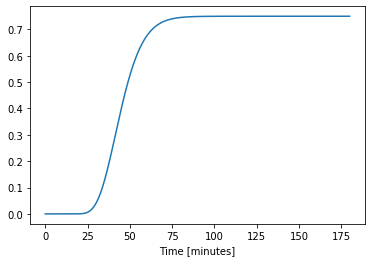

In [13]:
# Now call our function
Retard_pulse_solution = ADEwReactions_type1_fun(x, t, v, D, R, gamma, mu, C0, t0, Ci)
# Plot the results as a function of time
plt.plot(t/60, Retard_pulse_solution)
plt.xlabel('Time [minutes]')

## Activity:
### Comparison with conservative solute transport analytical model
To better evaulate how different parameters impact the model results, let's compare our reaction model results with the conservative solute transport model. We can use the same function as we defined above but now the retardation is equal to 1 ($k_d = 0$) and our first (```mu```) and zero order (```gamma```) reaction terms are equal to zero.

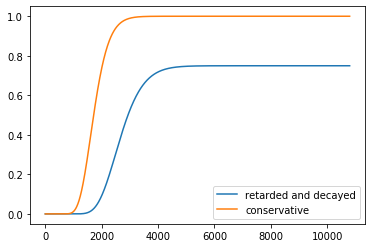

In [14]:
# Now call our reaction function with R = 1, gamma =0 and mu = 0
Conservative_pulse_solution = ADEwReactions_type1_fun(x, t, v, D, 1, 0, 0, C0, t0, Ci)

# Plot the results as a function of time
c1, = plt.plot(t, Retard_pulse_solution, label='retarded and decayed')
c2, = plt.plot(t, Conservative_pulse_solution, label='conservative')

# Format the plots
plt.legend(handles=[c1, c2])

# Finish labeling this plot

What controls the concentration of the breakthrough curve plateau? What controls the delay in the mean arrival time? 

### Zero-order term
What happens if the first order term is zero but the zero-order liquid phase source term (```gamma_w```) is equal to 0.0001? How is that different if (```gamma_s```) is equal to 0.0001? What does this physically correspond to?

### Finite pulse length
If you have time, explore the breakthrough curve behavior for pulse injections (with superposition). This is already implemented into the ```ADEwReactions_type1_fun``` function. To run the function with a finite pulse length the ```t0``` variable must be greater than zero. The value assigned to this variable gives the pulse injection time in seconds. To begin, define ```t0 = 60``` and keep all other parameters the same.